In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

methods =  ['mean', 'median', 'inter_linear', 'inter_cubic', 'inter_akima', 'inter_poly5', 'inter_spline5', 
            'mean_mov_3', 'backfill', 'ffill','pix','moment']

In [2]:

def get_all_input_paths(base_path):
    input_paths = []
    # Caminhar recursivamente pelas pastas
    for root, dirs, files in os.walk(base_path):
        if "imputed" in root:
            input_paths.append(root)
    return input_paths

In [3]:
dirs = np.sort(get_all_input_paths('./imputation_Statistics/experiments'))


In [4]:

for experiment in dirs:
    base = experiment.split('/')
    wind = int(base[4])
    input_data = []
    label_data = []
    index_s = []

    for s in np.sort(os.listdir("/".join(base[:-1])+'/input')):
        #parte dos dasdos reais e faltosos
        df_nan = pd.read_csv("/".join(base[:-1])+'/input/'+s, index_col=0)
        df_nan = df_nan.iloc[:(df_nan.shape[0]//wind)*wind, :].reset_index(drop=True)
        index = np.repeat(s[:-4], df_nan.shape[0])
        
        df_real = pd.read_csv("/".join(base[:-1])+'/label/'+s, index_col=0)
        df_real = df_real.iloc[:(df_real.shape[0]//wind)*wind, :].reset_index(drop=True)
        
        if df_real.shape[1] > 1:
            df_real = pd.DataFrame(df_real.to_numpy().flatten())
            df_nan = pd.DataFrame(df_nan.to_numpy().flatten())
        input_data.append(df_nan.to_numpy())
        label_data.append(df_real.to_numpy())
        index_s.append(np.repeat(s[:-4],df_nan.shape[0]))


    index_s = np.concatenate(index_s)

    label_data = pd.DataFrame(np.concatenate(label_data))  
    input_data = pd.DataFrame(np.concatenate(input_data))
    label_data['serie'] = index_s
    input_data['serie'] = index_s

    # salvar 
    label_data.to_csv(experiment+'/real_full_data.csv',index=False)
    input_data.to_csv(experiment+'/input_full_data.csv',index=False)

   
    

In [5]:
import os
import numpy as np
import pandas as pd


for experiment in dirs:
    base = experiment.split('/')
    wind = int(base[4])

    # DataFrame final para empilhar os resultados corretamente
    final_df = None
    index_s = []
   
    for s in  np.sort(os.listdir("/".join(base[:-1])+'/input')):
        temp = pd.DataFrame()  # Resetar 'temp' a cada novo arquivo de entrada
        columns = []
        
        for tecnic in methods:
            # Ignorar 'moment' e 'pix' com condições específicas
            if (tecnic == 'moment' and wind != 512) or (tecnic == 'pix' and wind != 1024):
                continue

            file_path = f"{experiment}/{tecnic}_{s}"

            # Verificar se o arquivo existe
            if os.path.exists(file_path):
                try:
                    # Carregar o arquivo CSV
                    df_inputed = pd.read_csv(file_path, index_col=0)

                    # Ajustar o tamanho da entrada com base em `wind`
                    df_inputed = df_inputed.iloc[:(df_inputed.shape[0] // wind) * wind, :].reset_index(drop=True)
                    
                    # Verificar se o DataFrame tem mais de uma coluna
                    if df_inputed.shape[1] > 1:
                        # Achatar o DataFrame para transformar múltiplas colunas em uma única série
                        df_inputed = pd.DataFrame(df_inputed.to_numpy().flatten())
                    
                    # Renomear a coluna para identificar o método
                    df_inputed.columns = [tecnic]
                    
                    # Adicionar o DataFrame temporário
                    temp = pd.concat([temp, df_inputed], axis=1)

                except Exception as e:
                    # Captura erros específicos durante o processamento de arquivos existentes
                    print(f"Erro ao processar o arquivo {file_path}: {e}")
            else:
                # Arquivo não encontrado
                print(f"Arquivo não encontrado: {file_path}")

        index_s.append(np.repeat(s[:-4],df_inputed.shape[0]))
        # Empilhar o DataFrame 'temp' no DataFrame 'final_df' ao longo das linhas (axis=0)
        if not temp.empty:
            if final_df is None:
                final_df = temp
            else:
                final_df = pd.concat([final_df, temp], axis=0)

    # Aqui você pode verificar o DataFrame final sem salvar
    if final_df is not None:
        # print(f"DataFrame final criado para o experimento: {experiment}")
        final_df['serie'] = np.concatenate(index_s)
       
        output_file = experiment+'/all_imputed.csv'
        final_df.to_csv(output_file, index=False)
        print(f"Salvou o DataFrame para {experiment} em {output_file}")
     


Salvou o DataFrame para ./imputation_Statistics/experiments/10/1024/teste/imputed em ./imputation_Statistics/experiments/10/1024/teste/imputed/all_imputed.csv
Salvou o DataFrame para ./imputation_Statistics/experiments/10/1024/treino/imputed em ./imputation_Statistics/experiments/10/1024/treino/imputed/all_imputed.csv
Salvou o DataFrame para ./imputation_Statistics/experiments/10/48/teste/imputed em ./imputation_Statistics/experiments/10/48/teste/imputed/all_imputed.csv
Salvou o DataFrame para ./imputation_Statistics/experiments/10/48/treino/imputed em ./imputation_Statistics/experiments/10/48/treino/imputed/all_imputed.csv
Salvou o DataFrame para ./imputation_Statistics/experiments/10/512/teste/imputed em ./imputation_Statistics/experiments/10/512/teste/imputed/all_imputed.csv
Salvou o DataFrame para ./imputation_Statistics/experiments/10/512/treino/imputed em ./imputation_Statistics/experiments/10/512/treino/imputed/all_imputed.csv
Salvou o DataFrame para ./imputation_Statistics/expe

Dados para estudo

In [5]:
import pandas as pd
import numpy as np

# Função personalizada para ASMAPE com tratamento de zeros

def asmape(y_true, y_pred):
    # Converte para arrays numpy se forem listas
    if isinstance(y_true, list) or isinstance(y_pred, list):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Cria uma máscara para excluir valores onde (y_true + y_pred) é zero ou NaN
    mask = (np.abs(y_true) + np.abs(y_pred)) != 0
    y_true, y_pred = y_true[mask], y_pred[mask]  # Aplicando a máscara

    # Calcula o comprimento do array filtrado sem NaNs
    len_ = np.count_nonzero(~np.isnan(y_pred))


    if len_ == 0:
        return 200  # Retorna NaN se não houver valores válidos para o cálculo

    # Calcula o ASMAPE com os valores válidos
    tmp = 100 * (np.nansum(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) / len_)

    return tmp



# Função personalizada para MAPE usando nansum e evitando divisões por zero
def mape_nansum(y_true, y_pred):
    # Evitar divisão por zero (y_true == 0)
    mask = (y_true != 0) & ~np.isnan(y_true)  # Apenas valores válidos e não zero
    if np.sum(mask) == 0:
        return np.nan  # Retorna NaN se não houver valores válidos
    # Calcular o MAPE ignorando NaN e divisões por zero
    mape_value = 100 * np.nansum(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) / np.sum(mask)
    return mape_value
# Função personalizada para MAE usando nansum
def mae_nansum(y_true, y_pred):
    mae_value = np.nansum(np.abs(y_true - y_pred)) / max(np.sum(~np.isnan(y_true)),1e-7)
    return mae_value


Dados para treino

In [ ]:
import numpy as np

# Função para criar a matriz binária
# Função para criar a matriz binária com limite de corte variável
import numpy as np

# Função para criar a matriz binária com limite de corte variável
def create_binary_matrix(metrics_df, asmape_columns):
    # Inicializar a matriz binária com zeros
    binary_matrix = pd.DataFrame(0, index=metrics_df.index, columns=asmape_columns)
    
    # Para cada linha, definir um limite de corte baseado no mínimo da linha
    for i in range(len(metrics_df)):
        # Remover valores NaN da linha para calcular o mínimo
        non_nan_row = metrics_df[asmape_columns].iloc[i].dropna()
        
        if not non_nan_row.empty:
            # Calcular o limite de corte como 1.5 vezes o valor mínimo da linha
            min_value = non_nan_row.min()
            threshold = 1.5 * min_value if min_value > 1e-10 else 1.5 * 1e-10
            
            # Garantir que o threshold é um número finito
            if not np.isfinite(threshold):
                threshold = 1.5  # Valor padrão de fallback, ou ajuste conforme necessário

            # Preencher a matriz binária onde os valores são menores ou iguais ao limite de corte
            binary_matrix.iloc[i] = (metrics_df[asmape_columns].iloc[i] <= threshold).astype(int)
            
            # Se a linha da matriz binária tiver apenas zeros, ajustar para que o mínimo receba 1
            if binary_matrix.iloc[i].sum() == 0:
                min_index = non_nan_row.idxmin()
                binary_matrix.at[i, min_index] = 1

    return binary_matrix




# Suponho que `dirs` seja a lista de diretórios que você está percorrendo
for experiment in dirs:
    # Definir janelas dos experimentos
    base = experiment.split('/')
    wind = int(base[4])
    
    # Ler resultados
    real = pd.read_csv(experiment + '/real_full_data.csv', low_memory=False)
    whit_nan = pd.read_csv(experiment + '/input_full_data.csv', low_memory=False)
    inputeds = pd.read_csv(experiment + '/all_imputed.csv', low_memory=False)

    # DataFrame para armazenar os valores e métricas por janela
    windowed_data = []

    # Para cada série
    for s in np.unique(real['serie']):
        real_serie = real[real['serie'] == s].drop(columns=['serie'])  # Remover coluna da série
        nan_serie = whit_nan[whit_nan['serie'] == s].drop(columns=['serie'])  # Remover coluna da série
        imput_serie = inputeds[inputeds['serie'] == s].drop(columns=['serie'])  # Remover coluna da série

        # Para cada janela de dados dentro da série
        for i in range(0, real_serie.shape[0], wind):
            # Definir a janela nos dados reais, com NaN e imputados
            r_window = real_serie.iloc[i:i + wind]  # Dados reais
            nan_window = nan_serie.iloc[i:i + wind]  # Dados com NaN (máscara)
            imput_window = imput_serie.iloc[i:i + wind, :]  # Dados imputados

            # Criar máscara de NaNs - converter para um array booleano para aplicação em séries
            mask = nan_window.isna().to_numpy().flatten()

            # Lista para armazenar as janelas de valores com NaN, reais e métricas
            window_row = []

            # Adicionar o identificador da série 's' como a primeira coluna
            window_row.append(s)

            # 1. Adicionar os valores com NaN
            window_row.extend(nan_window.to_numpy().flatten())

            # 2. Adicionar os valores reais
            window_row.extend(r_window.to_numpy().flatten())

            # 3. Calcular as métricas (MAE e ASMAPE) para cada método e adicionar
            for method in imput_window.columns:
                imput_method_window = imput_window[method].to_numpy()

                # Selecionar apenas as posições onde havia NaN na entrada (usando a máscara)
                r_valid = r_window.to_numpy()[mask].flatten()
                imput_valid = imput_method_window[mask].flatten()

                # Remover os NaN antes de calcular as métricas
                valid_mask = ~np.isnan(r_valid) & ~np.isnan(imput_valid)
                r_valid_filtered = r_valid[valid_mask]
                imput_valid_filtered = imput_valid[valid_mask]

                # Verificar se há dados válidos (evitar cálculo em janelas completamente vazias)
                if len(r_valid_filtered) > 0:
                    # Calcular as métricas usando nansum
                    mae_value = mae_nansum(r_valid_filtered, imput_valid_filtered)
                    asmape_value = asmape(r_valid_filtered, imput_valid_filtered)
                else:
                    mae_value =500
                    asmape_value = 200 #máximo asmape

                # Adicionar as métricas para este método (MAE e ASMAPE)
                window_row.append(mae_value)
                window_row.append(asmape_value)

            # Armazenar os dados da janela
            windowed_data.append(window_row)

    # Criar DataFrame para armazenar os resultados
    # As primeiras colunas serão para os valores com NaN, depois para os reais, depois para as métricas
    mae_columns = [f"mae_{method}" for method in imput_window.columns]  # Colunas para MAE
    asmape_columns = [f"asmape_{method}" for method in imput_window.columns]  # Colunas para ASMAPE
    columns = ['serie'] + [f"val_nan_{i}" for i in range(wind)] + [f"val_real_{i}" for i in range(wind)] + mae_columns + asmape_columns
    multilabel_columns = [f"multabel_{method}" for method in imput_window.columns]
    
    # Criar DataFrame final
    metrics_df = pd.DataFrame(windowed_data, columns=columns)

    multiclass = np.argmin(metrics_df[asmape_columns],axis=1)
    worst_case = np.argmax(metrics_df[asmape_columns],axis=1)

    # Criar uma matriz binária onde 1 indica valores <= threshold e 0 indica valores > threshold

    binary_matrix = create_binary_matrix(metrics_df[asmape_columns], asmape_columns)


    metrics_df['multiclass'] = multiclass
    metrics_df['worst_case'] = worst_case
    metrics_df[multilabel_columns] = binary_matrix.to_numpy()
    ## Exibir resultados
    print(f"Métricas calculadas para o experimento {experiment}")


    # Salvar o DataFrame com as métricas calculadas 
    output_file = f"{experiment}/data_full_processed.csv"
    metrics_df.to_csv(output_file, index=False)
    # print(f"Salvou o arquivo de métricas em {output_file}")

Métricas calculadas para o experimento ./imputation_Statistics/experiments/10/1024/teste/imputed
Métricas calculadas para o experimento ./imputation_Statistics/experiments/10/1024/treino/imputed
Métricas calculadas para o experimento ./imputation_Statistics/experiments/10/48/teste/imputed


Teste estatístico

In [4]:
import pandas as pd
import numpy as np
from scipy import stats

# Dicionário para armazenar os resultados por experimento
experiment_results = []

# Loop sobre cada experimento (presumo que `dirs` seja uma lista de diretórios)
for experiment in dirs:
    base = experiment.split('/')
    output_file = f"{experiment}/data_full_processed.csv"
    metrics_df = pd.read_csv(output_file)
    
    # Suponho que `metrics_df` já foi criado e contém as colunas de ASMAPE
    asmape_columns = [col for col in metrics_df.columns if 'asmape_' in col]

    # Identificar a janela (base[4]), o tipo (treino ou teste, base[5]), e a taxa de valores faltantes
    window_size = base[4]
    execution_type = base[5]  # 'treino' ou 'teste'
    missing_rate = base[3]    # Taxa de valores faltosos (10, 20, 30, etc.)

    # Agrupar os dados inteiros sem se preocupar com as séries individuais
    fixed_smape_per_window = []
    best_smape_per_window = []

    # 1. Calcular a média de SMAPE para cada técnica em todos os dados
    smape_means_per_method = metrics_df[asmape_columns].mean()

    # Encontrar a técnica com a menor média de SMAPE
    best_method_overall = smape_means_per_method.idxmin()  # Nome do método com menor SMAPE
    fixed_smape_per_window = metrics_df[best_method_overall]  # Usar essa técnica em todas as janelas

    # 2. Abordagem com melhores métodos por janela (usando o menor SMAPE para cada janela)
    best_smape_per_window = metrics_df[asmape_columns].min(axis=1)  # Melhor SMAPE em cada janela
  

    # Verificar se há NaNs e remover linhas com NaNs em ambas as abordagens
    valid_mask = ~best_smape_per_window.isna() & ~fixed_smape_per_window.isna()

    # Se houver dados válidos suficientes
    if valid_mask.sum() > 1:
        # Adicionar os valores válidos para a comparação no experimento atual
        fixed_smape_per_window = fixed_smape_per_window[valid_mask].values
        best_smape_per_window = best_smape_per_window[valid_mask].values

        # Realizar o teste t pareado para comparar as duas abordagens
        t_stat, p_value = stats.ttest_rel(best_smape_per_window, fixed_smape_per_window)

        # Calcular as médias dos SMAPEs
        mean_fixed_smape = np.mean(fixed_smape_per_window) if len(fixed_smape_per_window) > 0 else 200
        mean_best_smape_per_window = np.mean(best_smape_per_window) if len(best_smape_per_window) > 0 else 200

        # Armazenar os resultados para a janela, tipo de execução e taxa de valores faltosos
        experiment_results.append({
            'experiment': f'{missing_rate}-{window_size}-{execution_type}',  # Incluindo a taxa de valores faltosos
            't_stat': t_stat,
            'p_value': p_value,
            'mean_fixed_smape': mean_fixed_smape,
            'mean_best_smape_per_window': mean_best_smape_per_window
            
        })

# Converter os resultados para um DataFrame para facilitar a visualização
experiment_results_df = pd.DataFrame(experiment_results)

# Marcar quais experimentos têm resultados estatisticamente significativos (p < 0.05)
experiment_results_df['significant'] = experiment_results_df['p_value'] < 0.05

# Salvar os resultados em um arquivo CSV para visualização posterior
# experiment_results_df.to_csv('experiment_results_by_window_and_missing_rate.csv', index=False)



In [5]:
experiment_results_df.head(18)

,experiment,t_stat,p_value,mean_fixed_smape,mean_best_smape_per_window,significant
0,10-1024-teste,-90.463497,0.000000e+00,6.117130,4.395202,True
1,10-1024-treino,-45.742084,0.000000e+00,4.021548,3.463380,True
2,10-48-teste,-125.457447,0.000000e+00,14.139642,6.027646,True
3,10-48-treino,-201.890616,0.000000e+00,12.436235,6.098980,True
4,10-512-teste,-32.256675,2.226377e-223,6.790021,4.416754,True
5,10-512-treino,-147.897229,0.000000e+00,6.010400,4.504291,True
6,20-1024-teste,-89.297650,0.000000e+00,6.585782,4.744439,True
7,20-1024-treino,-45.886948,0.000000e+00,4.604409,3.983108,True
8,20-48-teste,-119.654615,0.000000e+00,11.472333,3.950312,True
9,20-48-treino,-190.253445,0.000000e+00,9.820979,4.024703,True


In [6]:
# Filtrar os experimentos que contêm a palavra "teste" na coluna 'experiment'
test_experiments_df = experiment_results_df[experiment_results_df['experiment'].str.contains('teste')]

# Exibir os resultados filtrados
test_experiments_df.head(15)


,experiment,t_stat,p_value,mean_fixed_smape,mean_best_smape_per_window,significant
0,10-1024-teste,-90.463497,0.000000e+00,6.117130,4.395202,True
2,10-48-teste,-125.457447,0.000000e+00,14.139642,6.027646,True
4,10-512-teste,-32.256675,2.226377e-223,6.790021,4.416754,True
6,20-1024-teste,-89.297650,0.000000e+00,6.585782,4.744439,True
8,20-48-teste,-119.654615,0.000000e+00,11.472333,3.950312,True
10,20-512-teste,-34.028013,9.439957e-248,7.210420,4.862239,True
12,30-1024-teste,-101.614594,0.000000e+00,7.168778,5.055550,True
14,30-48-teste,-119.881805,0.000000e+00,11.927328,4.433662,True
16,30-512-teste,-36.615651,1.838450e-285,7.777428,5.279761,True


Distribuição do depenho dos métododos nos dados

In [134]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Função para renomear os métodos
# def rename_method(method):
#     replacements = {
#         'asmape_pix': 'pix2pix',
#         'asmape_mean': 'mean',
#         'asmape_median': 'median',
#         'asmape_ffill': 'ffill',
#         'asmape_backfill': 'backfill',
#         'asmape_moment': 'Moment',
#         'asmape_mean_mov_3': 'mean_mov_3',
#         'asmape_inter_spline5': 'interpolation_spline5',
#         'asmape_inter_poly5': 'interpolation_poly5',
#         'asmape_inter_cubic': 'interpolation_cubic',
#         'asmape_inter_akima': 'interpolation_akima',
#         'asmape_inter_linear': 'interpolation_linear'
#     }
#     return replacements.get(method, method)  # Se não encontrar, mantém o nome original

# # Função para determinar o estilo do hatch com base se é treino ou teste
# def get_hatch(type_window):
#     return '' if type_window == 'treino' else '///'  # Treino sem hatch, teste com hatch de listras

# # Armazenar as classes (melhores técnicas) por experimento
# classes = {}

# # Variável para armazenar o tamanho da janela dos experimentos
# window_sizes = {}  # Ex: {'exp_name': (window_size, type_window)}

# for experiment in dirs:
#     output_file = f"{experiment}/data_full_processed.csv"
#     metrics_df = pd.read_csv(output_file)

#     # Obter o tamanho da janela (como inteiro) e tipo de janela (treino ou teste)
#     window_size = int(experiment.split('/')[4])  # Índice 4 para o tamanho da janela
#     type_window = experiment.split('/')[5]       # Índice 5 para 'treino' ou 'teste'
#     window_sizes[f"{window_size}-{type_window}"] = (window_size, type_window)  # Corrigido para garantir consistência

#     # Suponho que `metrics_df` já foi criado e contém as colunas de ASMAPE
#     asmape_columns = [col for col in metrics_df.columns if 'asmape_' in col]

#     # Encontrar os índices das colunas com os menores valores de ASMAPE para cada linha
#     mins = np.argmin(metrics_df[asmape_columns].values, axis=1)

#     # Extrair o nome do método correspondente ao menor ASMAPE
#     smape_min_methods = np.array(asmape_columns)[mins]

#     # Criar uma chave identificando o experimento (usando partes do caminho)
#     exp_name = f"{window_size}-{type_window}"  # Usando tamanho da janela e tipo (treino/teste)

#     # Armazenar a lista de melhores métodos (classes) por experimento
#     classes[exp_name] = smape_min_methods

# # Atualizar lista de métodos globais para evitar erro de métodos ausentes
# all_methods = list(set(np.concatenate(list(classes.values()))))  # Captura todos os métodos de todos os experimentos

# # Renomear os métodos para a exibição
# all_methods_renamed = [rename_method(method) for method in all_methods]

# # Criar DataFrame para armazenar frequências normalizadas por experimento
# freq_df = pd.DataFrame(0.0, index=all_methods_renamed, columns=classes.keys(), dtype=float)  # Alterado para dtype=float

# # Preencher o DataFrame com a contagem de cada método por experimento e normalizar
# for exp_name, methods in classes.items():
#     unique, counts = np.unique(methods, return_counts=True)
#     total = len(methods)  # Total de ocorrências para normalizar
#     for method, count in zip(unique, counts):
#         renamed_method = rename_method(method)
#         freq_df.loc[renamed_method, exp_name] = count / total  # Normalização

# # Configurações para o gráfico
# fig, ax = plt.subplots(figsize=(14, 8))  # Aumentar o tamanho do gráfico

# # Gerar um índice para as posições das barras (um para cada técnica)
# indices = np.arange(len(all_methods))
# bar_width = 0.1  # Reduzir a largura das barras

# # Mapeamento de cores baseado no tamanho da janela
# window_size_colors = {}
# unique_window_sizes = np.unique([ws[0] for ws in window_sizes.values()])
# colors = plt.colormaps.get_cmap('tab10')  # Atualizado para a versão correta

# # Associar uma cor a cada tamanho de janela
# for i, window_size in enumerate(unique_window_sizes):
#     window_size_colors[window_size] = colors(i / len(unique_window_sizes))  # Ajuste para garantir cores distintas

# # Plotar a distribuição de classes normalizadas para cada experimento
# for i, (exp_name, methods) in enumerate(classes.items()):
#     window_size, type_window = window_sizes[exp_name]  # Obter o tamanho da janela e o tipo (treino ou teste)
#     color = window_size_colors[window_size]  # Obter a cor associada ao tamanho da janela
#     hatch = get_hatch(type_window)  # Determinar o hatch (padrão de preenchimento)

#     # Tradução do tipo da janela para inglês
#     type_window_english = 'train' if type_window == 'treino' else 'test'

#     # Simplificação da legenda
#     ax.bar(indices + i * (bar_width + 0.02), freq_df[exp_name], bar_width,
#            label=f"{type_window_english} ({window_size})", color=color, edgecolor='black', hatch=hatch)

# # Adicionar linhas de grade para facilitar a visualização
# ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# # Adicionar rótulos e título
# ax.set_xlabel('Method')
# ax.set_ylabel('Proportion')
# ax.set_title('Normalized Distribution of Best Methods by Experiment')
# ax.set_xticks(indices + bar_width * (len(classes) - 1) / 2)  # Centralizar os ticks
# ax.set_xticklabels(all_methods_renamed, rotation=45, ha='right')

# # Mostrar a legenda
# ax.legend(loc='upper right')

# # Ajustar layout
# plt.tight_layout()

# # Exibir o gráfico
# plt.show()


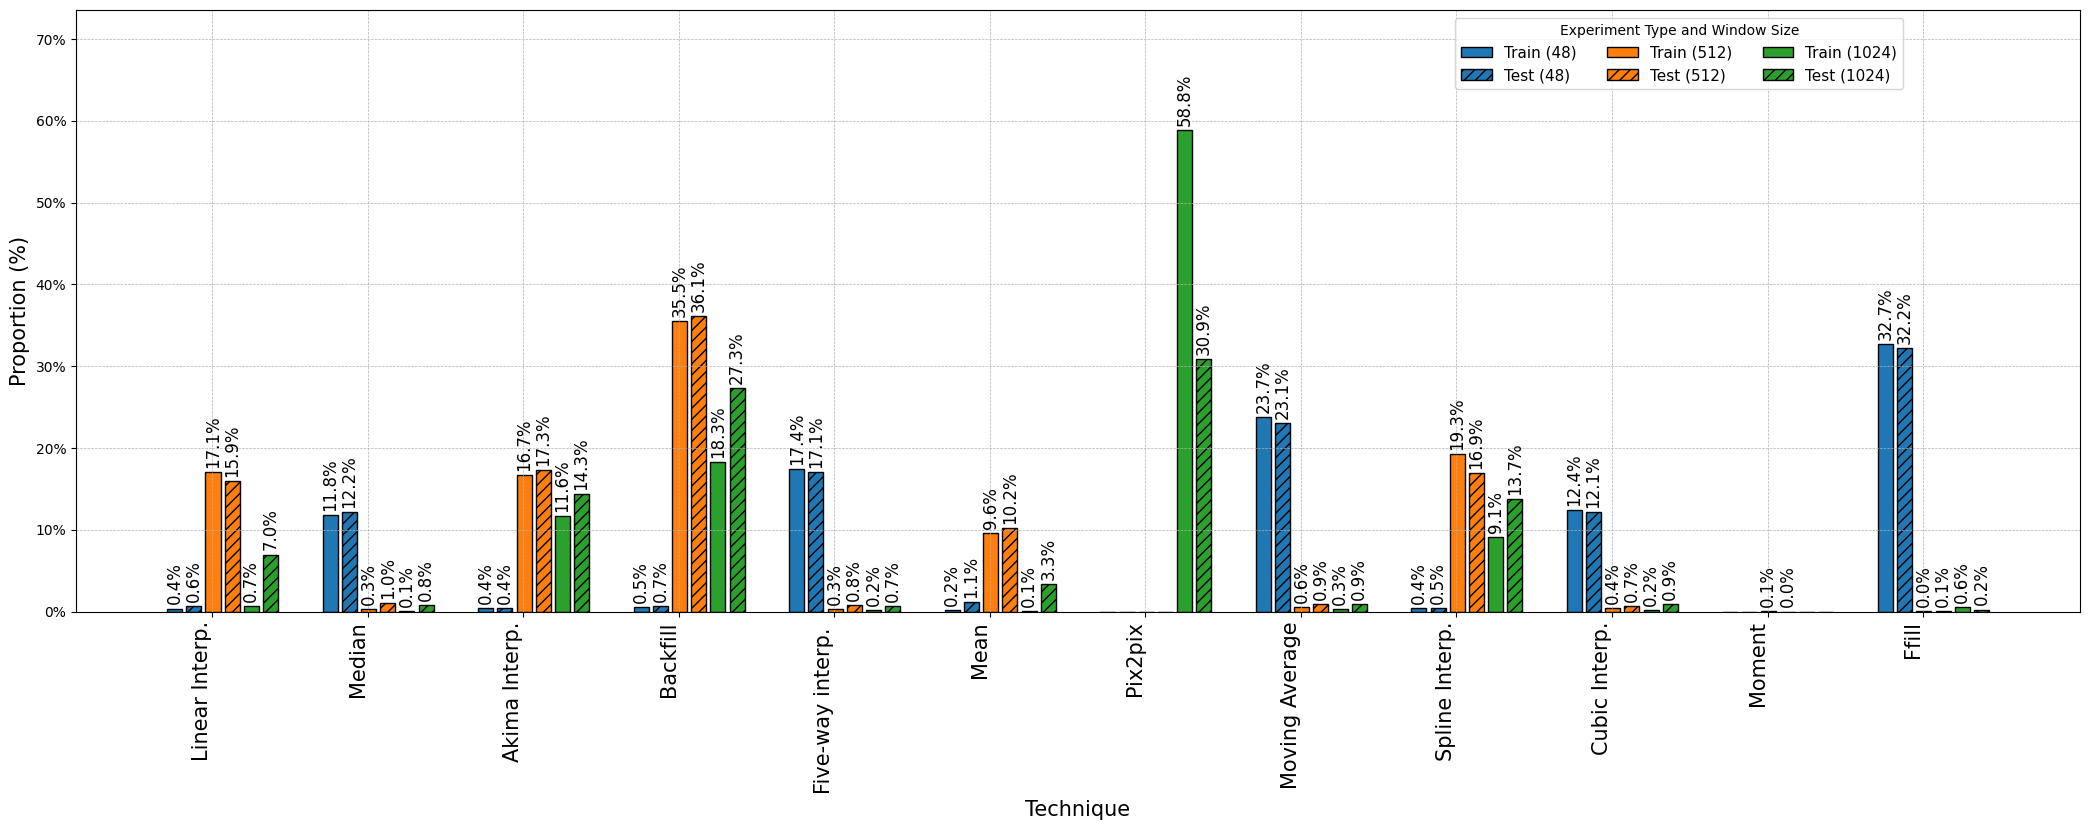

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick  # Importar para formatação de porcentagem
import os
import seaborn as sns

# Função para renomear os métodos
def rename_method(method):
    replacements = {
        'asmape_pix': 'Pix2pix',
        'asmape_mean': 'Mean',
        'asmape_median': 'Median',
        'asmape_ffill': 'Ffill',
        'asmape_backfill': 'Backfill',
        'asmape_moment': 'Moment',
        'asmape_mean_mov_3': 'Moving Average',
        'asmape_inter_spline5': 'Spline Interp.',
        'asmape_inter_poly5': 'Five-way interp. ',
        'asmape_inter_cubic': 'Cubic Interp.',
        'asmape_inter_akima': 'Akima Interp.',
        'asmape_inter_linear': 'Linear Interp.'
    }
    return replacements.get(method, method)  # Se não encontrar, mantém o nome original

# Função para determinar o estilo do hatch com base se é treino ou teste
def get_hatch(type_window):
    return '' if type_window == 'treino' else '///'  # Treino sem hatch, teste com hatch de listras

# Armazenar as classes (melhores técnicas) por experimento
classes = {}

# Variável para armazenar o tamanho da janela dos experimentos
window_sizes = {} 

for experiment in dirs:
    output_file = f"{experiment}/data_full_processed.csv"
    
    # Verificar se o arquivo existe
    if not os.path.isfile(output_file):
        print(f"Arquivo {output_file} não encontrado. Pular este experimento.")
        continue  # Pula para o próximo experimento
    
    metrics_df = pd.read_csv(output_file)

    # Obter o tamanho da janela (como inteiro) e tipo de janela (treino ou teste)
    try:
        path_parts = experiment.split('/')  # Ajuste conforme o separador do seu sistema operacional
        window_size = int(path_parts[4])  # Índice 4 para o tamanho da janela
        type_window = path_parts[5]       # Índice 5 para 'treino' ou 'teste'
    except IndexError:
        print(f"Erro: O caminho '{experiment}' não possui partes suficientes.")
        continue  # Pula para o próximo experimento
    except ValueError:
        print(f"Erro: O tamanho da janela em '{experiment}' não é um número válido.")
        continue  # Pula para o próximo experimento

    window_sizes[f"{window_size}-{type_window}"] = (window_size, type_window)  # Garantir consistência

    # Verificar se existem colunas ASMAPE
    asmape_columns = [col for col in metrics_df.columns if 'asmape_' in col]
    if not asmape_columns:
        print(f"Nenhuma coluna ASMAPE encontrada em {output_file}. Pular este experimento.")
        continue

    # Encontrar os índices das colunas com os menores valores de ASMAPE para cada linha
    mins = np.argmin(metrics_df[asmape_columns].values, axis=1)

    # Extrair o nome do método correspondente ao menor ASMAPE
    smape_min_methods = np.array(asmape_columns)[mins]

    # Criar uma chave identificando o experimento (usando tamanho da janela e tipo)
    exp_name = f"{window_size}-{type_window}"  # Usando tamanho da janela e tipo (treino/teste)

    # Armazenar a lista de melhores métodos (classes) por experimento
    classes[exp_name] = smape_min_methods

# Atualizar lista de métodos globais para evitar erro de métodos ausentes
all_methods = list(set(np.concatenate(list(classes.values()))))  # Captura todos os métodos de todos os experimentos

# Renomear os métodos para a exibição
all_methods_renamed = [rename_method(method) for method in all_methods]

# Criar DataFrame para armazenar frequências normalizadas por experimento
freq_df = pd.DataFrame(0.0, index=all_methods_renamed, columns=classes.keys(), dtype=float)  # Alterado para dtype=float

# Reorganizar as colunas do DataFrame existente
desired_order = ["48-treino", "48-teste", "512-treino", "512-teste", "1024-treino", "1024-teste"]

# Reordenar o dicionário
sorted_classes = {key: classes[key] for key in desired_order}
# Preencher o DataFrame com a contagem de cada método por experimento e normalizar
for exp_name, methods in classes.items():
    unique, counts = np.unique(methods, return_counts=True)
    total = len(methods)  # Total de ocorrências para normalizar
    for method, count in zip(unique, counts):
        renamed_method = rename_method(method)
        freq_df.loc[renamed_method, exp_name] = count / total  # Normalização

fig, ax = plt.subplots(figsize=(15, 8))  # Aumentar o tamanho do gráfico

# Gerar índices para as posições dos grupos
group_spacing_factor = 3  # Fator maior para aumentar o espaço entre grupos
indices = np.arange(len(all_methods)) * group_spacing_factor

bar_width = 0.29  # Largura das barras
spacing = 0.08  # Espaçamento entre barras dentro do mesmo grupo

# Mapeamento de cores baseado no tamanho da janela
window_size_colors = {}
unique_window_sizes = np.unique([ws[0] for ws in window_sizes.values()])
colors = plt.cm.tab10  # Utilizar colormap 'tab10'

# Associar uma cor a cada tamanho de janela
for i, window_size in enumerate(unique_window_sizes):
    window_size_colors[window_size] = colors(i % 10)  # Garantir cores distintas

# Plotar a distribuição de classes normalizadas para cada experimento
for i, (exp_name, methods) in enumerate(sorted_classes.items()):
    window_size, type_window = window_sizes[exp_name]
    color = window_size_colors[window_size]
    hatch = get_hatch(type_window)

    # Tradução do tipo da janela para inglês
    type_window_english = 'Train' if type_window == 'treino' else 'Test'

    # Plotar as barras com espaçamento interno (dentro do grupo) e externo (entre os grupos)
    bars = ax.bar(
        indices + i * (bar_width + spacing) - bar_width * (len(classes) - 1) / 2, 
        freq_df[exp_name],
        bar_width,
        label=f"{type_window_english} ({window_size})",
        color=color,
        edgecolor='black',
        hatch=hatch
    )

    # Adicionar rótulos de porcentagem acima das barras
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + .005,
                f'{height * 100:.1f}%',
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=90,  # Rotacionar os rótulos em 90 graus
                color='black'
            )

# Adicionar linhas de grade para facilitar a visualização
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adicionar rótulos e título
ax.set_xlabel('Technique', fontsize=15)
ax.set_ylabel('Proportion (%)', fontsize=15)  # Ajustar o rótulo para indicar porcentagem
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Formatar o eixo y como porcentagem

# Ajustar os limites do eixo y para espaço adicional acima das barras
y_max = freq_df.max().max()
ax.set_ylim(0, y_max * 1.25)  # Adiciona 25% de espaço acima

# Ajustar os ticks do eixo x
ax.set_xticks(indices)  # Centralizar os ticks
ax.set_xticklabels(all_methods_renamed, rotation=90, ha='right', fontsize=15)

# Mostrar a legenda acima das barras, arranjada verticalmente
ax.legend(
    loc='upper center',
    bbox_to_anchor=(.8, 1),
    ncol=3,
    title='Experiment Type and Window Size',
    fontsize=11
)

# Ajustar layout para evitar sobreposição
plt.tight_layout(rect=[-0.4, -0.1, 1, 0.95]) 
plt.show()

In [166]:
freq_df

,1024-teste,1024-treino,48-teste,48-treino,512-teste,512-treino
Linear Interp.,0.069759,0.007046,0.006234,0.003729,0.159392,0.171000
Median,0.008076,0.000546,0.121930,0.118200,0.010227,0.002798
Akima Interp.,0.143385,0.116307,0.003811,0.003863,0.173299,0.166684
Backfill,0.272938,0.183290,0.006744,0.005308,0.361489,0.355374
Five-way interp.,0.006701,0.001524,0.170918,0.174193,0.007659,0.003378
Mean,0.033162,0.001150,0.011175,0.002388,0.102182,0.096401
Pix2pix,0.308591,0.588381,0.000000,0.000000,0.000000,0.000000
Moving Average,0.008763,0.002819,0.230771,0.237296,0.009414,0.005971
Spline Interp.,0.137285,0.090825,0.004835,0.003881,0.169063,0.192989
Cubic Interp.,0.008849,0.002358,0.121314,0.123645,0.006675,0.004384


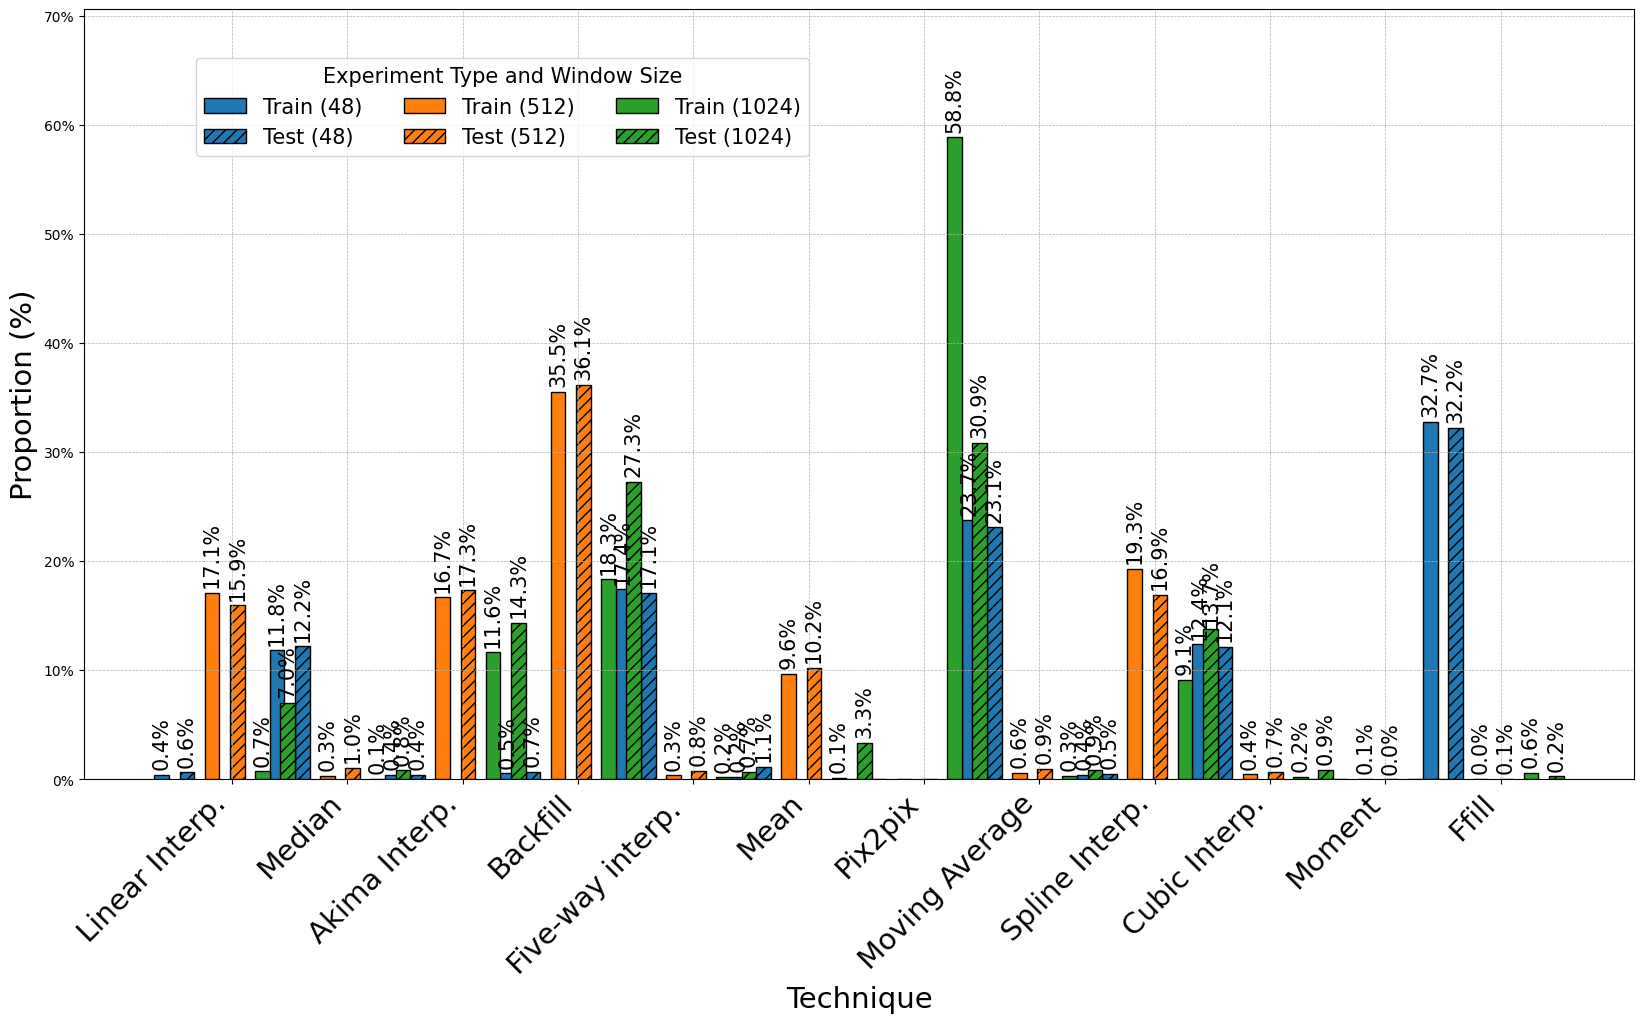

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))  # Aumentar o tamanho do gráfico

# Gerar índices para as posições dos grupos (começando no zero)
group_spacing_factor = 3.5  # Espaçamento entre grupos
indices = np.arange(len(all_methods)) * group_spacing_factor  # Espaçamento uniforme, começando no zero

bar_width = 0.7  # Largura das barras
spacing = 0.5  # Espaçamento entre barras dentro do mesmo grupo

# Calcular o deslocamento total do grupo para alinhar ao zero
total_width = len(classes) * bar_width + (len(classes) - 1) * spacing  # Largura total de cada grupo

# Mapeamento de cores baseado no tamanho da janela
window_size_colors = {}
unique_window_sizes = np.unique([ws[0] for ws in window_sizes.values()])
colors = plt.cm.tab10  # Utilizar colormap 'tab10'

# Associar uma cor a cada tamanho de janela
for i, window_size in enumerate(unique_window_sizes):
    window_size_colors[window_size] = colors(i % 10)  # Garantir cores distintas

# Plotar a distribuição de classes normalizadas para cada experimento
for i, (exp_name, methods) in enumerate(sorted_classes.items()):
    window_size, type_window = window_sizes[exp_name]
    color = window_size_colors[window_size]
    hatch = get_hatch(type_window)

    # Tradução do tipo da janela para inglês
    type_window_english = 'Train' if type_window == 'treino' else 'Test'

    # Plotar as barras, alinhando o primeiro grupo ao eixo Y
    bars = ax.bar(
        indices + i * (bar_width + spacing) - total_width / 2,  # Ajuste de centralização
        freq_df[exp_name],
        bar_width,
        label=f"{type_window_english} ({window_size})",
        color=color,
        edgecolor='black',
        hatch=hatch
    )

    # Adicionar rótulos de porcentagem acima das barras
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + .005,
                f'{height * 100:.1f}%',
                ha='center',
                va='bottom',
                fontsize=15,
                rotation=90,
                color='black'
            )

# Adicionar linhas de grade para facilitar a visualização
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adicionar rótulos e título
ax.set_xlabel('Technique', fontsize=21)
ax.set_ylabel('Proportion (%)', fontsize=21)  # Ajustar o rótulo para indicar porcentagem
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Formatar o eixo y como porcentagem

# Ajustar os limites do eixo y para espaço adicional acima das barras
y_max = freq_df.max().max()
ax.set_ylim(0, y_max * 1.2)  # Adiciona 25% de espaço acima

# Ajustar os ticks do eixo x
ax.set_xticks(indices)  # Centralizar os ticks
ax.set_xticklabels(all_methods_renamed, rotation=45, ha='right', fontsize=21)

# Mostrar a legenda acima das barras, arranjada verticalmente
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.27, .95),  # Posicionar a legenda acima
    ncol=3,
    fontsize=15,
    title='Experiment Type and Window Size',
    title_fontsize=15,
  
 
)

# Ajustar layout para evitar sobreposição
plt.tight_layout(rect=[-0.2, 0, -.5, .5])  # Ajuste fino no layout
plt.show()


In [ ]:
import warnings
warnings.simplefilter("ignore")

result = {}
for experiment in dirs:
    output_file = f"{experiment}/data_full_processed.csv"
    metrics_df = pd.read_csv(output_file)
    
    # Verificar se o arquivo existe
    if not os.path.isfile(output_file):
        print(f"Arquivo {output_file} não encontrado. Pular este experimento.")
        continue  # Pula para o próximo experimento
    
    metrics_df = pd.read_csv(output_file)
    data = metrics_df[['serie','multiclass']]
    data['id'] = [int("".join(i.split('_')[0])) for i in data['serie']]
    data['serie'] = ["_".join(i.split('_')[1:]) for i in data['serie']]

    for s in data.serie.unique():
        temp = data[data['serie'] == s]
        ids_in_serie = temp.id.unique()
        s_list = []
    
        for ids in ids_in_serie:
            df_id = temp[temp['id'] == ids]#['multiclass'].reset_index(drop=True)
        
        #     s_list.append(df_id)
            result[s]=[df_id[df_id['multiclass'] == df_id['id']].shape[0],df_id[df_id['multiclass'] != df_id['id']].shape[0]]

df = pd.DataFrame(result).T
df = df.set_axis(['Equal','Different'],axis='columns')  


In [ ]:
dataset_acronyms = {
    "AirPassengers": "AP",
    "monthly_beer_production_in_austr": "MBPA",
    "aeration-rate": "AR",
    "ammonia": "AMM",
    "Bike Sharing": "BSH",
    "Sunspots": "SU",
    "Birmingham Parking": "PB",
    "daily-minimum-temperatures-in-me": "DMTME",
    "electricity-usage": "EU",
    "LD2011_2014": "ELD",
    "paper-basis-weight": "PBW",
    "distillate-flow": "Dest"
}

df.rename(dataset_acronyms,axis=0,inplace=True)
# for a better visualisation let's cut the datset with many samples 
df.loc['ELD','Different'] = 100


<Axes: >

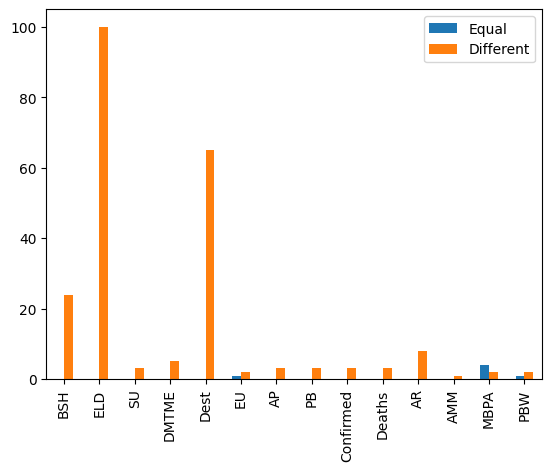

In [133]:
df.plot(kind='bar')